### Загрузка библиотек и функций:

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd
import pickle   
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Загрузка данных:

In [8]:
TRAIN_DATASET_PATH = './/course_project_train.csv'
TEST_DATASET_PATH = './/course_project_test.csv'
TRAIN_PREPARED_DATASET_PATH = './/prepared_train_DS_2.csv'
TEST_PREPARED_DATASET_PATH = './/prepared_test_DS_2.csv'

### Обзор датасета:

In [9]:
dftr = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
dftr.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
dftst = pd.read_csv(TEST_DATASET_PATH, sep=',')
dftst.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [11]:
dftr.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [12]:
dftst.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [13]:
dftr.index

RangeIndex(start=0, stop=7500, step=1)

In [14]:
dftst.index

RangeIndex(start=0, stop=2500, step=1)

### Целевая переменная:

In [15]:
dftr['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Обзор номинативных признаков:

In [16]:
for cat_colname in dftr.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(dftr[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [17]:
for cat_colname in dftst.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(dftst[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

#### Обзор количественных признаков:
#### Для корректного отображения данных изменим формат отображения float64. 

In [18]:
pd.options.display.float_format ='{:,.2f}'.format

In [19]:
dftr.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,"5,943.00","7,500.00","7,500.00","7,500.00","7,500.00","7,500.00","3,419.00","7,486.00","7,500.00","7,500.00","7,500.00","5,943.00","7,500.00"
mean,"1,366,391.72",0.03,11.13,18.32,"945,153.73",0.17,34.69,0.12,"11,873,177.45","289,833.24","18,314.45","1,151.09",0.28
std,"845,339.20",0.27,4.91,7.04,"16,026,216.67",0.50,21.69,0.35,"31,926,122.97","317,871.38","11,926.76","1,604.45",0.45
min,"164,597.00",0.00,2.00,4.00,0.00,0.00,0.00,0.00,"11,242.00",0.00,0.00,585.00,0.00
25%,"844,341.00",0.00,8.00,13.50,"279,229.50",0.00,16.00,0.00,"180,169.00","114,256.50","10,067.50",711.00,0.00
50%,"1,168,386.00",0.00,10.00,17.00,"478,159.00",0.00,32.00,0.00,"309,573.00","209,323.00","16,076.50",731.00,0.00
75%,"1,640,137.00",0.00,14.00,21.80,"793,501.50",0.00,50.00,0.00,"519,882.00","360,406.25","23,818.00",743.00,1.00
max,"10,149,344.00",7.00,43.00,57.70,"1,304,726,170.00",7.00,118.00,4.00,"99,999,999.00","6,506,797.00","136,679.00","7,510.00",1.00


In [20]:
dftst.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,"1,987.00","2,500.00","2,500.00","2,500.00","2,500.00","2,500.00","1,142.00","2,497.00","2,500.00","2,500.00","2,500.00","1,987.00"
mean,"1,366,921.68",0.04,11.18,18.33,"710,570.41",0.16,34.18,0.11,"12,155,719.63","296,396.65","18,271.34","1,234.52"
std,"917,125.15",0.39,4.85,7.25,"1,511,983.48",0.56,22.02,0.36,"32,260,973.72","378,301.97","11,543.88","1,740.22"
min,"106,533.00",0.00,1.00,3.90,0.00,0.00,0.00,0.00,"15,422.00",0.00,93.00,585.00
25%,"852,311.50",0.00,8.00,13.40,"278,586.00",0.00,16.00,0.00,"187,126.50","110,114.50","10,024.75",710.00
50%,"1,178,475.00",0.00,10.00,17.00,"478,676.00",0.00,30.00,0.00,"322,366.00","207,385.00","16,642.50",731.00
75%,"1,629,734.50",0.00,14.00,22.10,"802,598.50",0.00,50.00,0.00,"522,582.50","366,348.50","24,146.00",743.00
max,"14,975,610.00",15.00,48.00,53.40,"54,484,386.00",15.00,82.00,5.00,"99,999,999.00","6,030,087.00","93,555.00","7,480.00"


In [21]:
pd.reset_option('display.float_format')

### Устранение выбросов:

#### Обнаружение выбросов производилось с помощью BoxPlotb, гистограммы и самостоятельных логических решений.

#### Было принято решение все значения признака 'Home Ownership' 'Have Mortgage' считать за выбросы и привести их к моде.

In [22]:
dftr.replace({'Home Ownership':{'Have Mortgage': dftr['Home Ownership'].mode()[0]}}, inplace=True)
dftst.replace({'Home Ownership':{'Have Mortgage': dftst['Home Ownership'].mode()[0]}}, inplace=True)

In [23]:
dftr['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [24]:
dftst['Home Ownership'].value_counts()

Home Mortgage    1232
Rent             1020
Own Home          248
Name: Home Ownership, dtype: int64

#### Было принято решение все значения 'Annual Income' > 4 000 000 считать за выбросы и привести их к медиане.

In [25]:
(dftr['Annual Income'] > 4000000).sum()

91

In [26]:
(dftst['Annual Income'] > 4000000).sum()

27

In [27]:
dftr.loc[dftr['Annual Income'] > 4000000,'Annual Income'] = dftr.loc[dftr['Annual Income'] < 4000000,'Annual Income'].median()
dftst.loc[dftst['Annual Income'] > 4000000,'Annual Income'] = dftst.loc[dftst['Annual Income'] < 4000000,'Annual Income'].median()

#### В виду того, что в признаке 'Tax Liens' все значения > 0 считаются выбросами, принято решение удалить данный признак.

In [28]:
dftr['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [29]:
dftst['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
6.0        1
5.0        1
3.0        1
4.0        1
Name: Tax Liens, dtype: int64

In [30]:
dftr.drop('Tax Liens', axis=1, inplace=True)
dftst.drop('Tax Liens', axis=1, inplace=True)

#### Принято решение считать 'Number of Open Accounts' > 23 выбросами. Заменяем на медиану.

In [31]:
dftr.loc[dftr['Number of Open Accounts'] > 23,'Number of Open Accounts'] = dftr['Number of Open Accounts'].median()
dftst.loc[dftst['Number of Open Accounts'] > 23,'Number of Open Accounts'] = dftst['Number of Open Accounts'].median()

#### В соответствие с показаниями BoxPlot, 'Years of Credit History' > 35 считаем за выбросы и заменяем медианой.

In [32]:
dftr.loc[dftr['Years of Credit History'] > 35,'Years of Credit History'] = dftr['Years of Credit History'].median()
dftst.loc[dftst['Years of Credit History'] > 35,'Years of Credit History'] = dftst['Years of Credit History'].median()

#### В признаке 'Maximum Open Credit' за выбросы считаем значения больше 2 000 000. Заменяем медианой.

In [33]:
dftr.loc[dftr['Maximum Open Credit'] > 2000000,'Maximum Open Credit'] = dftr.loc[dftr['Maximum Open Credit'] < 2000000,'Maximum Open Credit'].median()
dftst.loc[dftst['Maximum Open Credit'] > 2000000,'Maximum Open Credit'] = dftst.loc[dftst['Maximum Open Credit'] < 2000000,'Maximum Open Credit'].median()

#### В признаке 'Number of Credit Problems' обнаружено возможно ошибочное значение. Заменяем на 6.

In [34]:
dftst.loc[dftst['Number of Credit Problems'] == 15,'Number of Credit Problems'] = 6

#### В признаке 'Months since last delinquent' в тренировочной выборке обнаружен один выброс. Заменяем модой.

In [35]:
dftr.loc[dftr['Months since last delinquent'] > 100,'Months since last delinquent']=dftr['Months since last delinquent'].mode()

#### Применяя логику здравого смысла, считаем за выбросы в признаке 'Bankruptcies' все значения больше 5 и заменяем их медианой.

In [36]:
dftr.loc[dftr['Bankruptcies'] > 5,'Bankruptcies'] = dftr['Bankruptcies'].median()
dftst.loc[dftst['Bankruptcies'] > 5,'Bankruptcies'] = dftst['Bankruptcies'].median()

#### За выброс в признаке 'Current Loan Amount' считаем слишком большое значение 99999999.0. Принято решение заменить на моду (0.0).

In [37]:
dftr.loc[dftr['Current Loan Amount']>1000000,'Current Loan Amount'] = dftr.loc[dftr['Current Loan Amount']<10000000, 'Current Loan Amount'].mode()[0]
dftst.loc[dftst['Current Loan Amount']>1000000,'Current Loan Amount'] = dftst.loc[dftst['Current Loan Amount']<10000000, 'Current Loan Amount'].mode()[0]

#### Между признаками Current Loan Amount и Current Credit Balance не выявлено закономерности в том, что один должен быть больше другого или наоборот. И так как Current Credit Balance вероятно отображает количество денег на счете, логично предположить, что их может быть сколько угодно, а с учетом того, что явных больших аномальных значений нет, считаем, что выбросов в данном признаке не наблюдается.

#### Так как между признаками Monthly Debt и Current Loan Amount наблюдается очень сильная линейная зависимость, и в признакае Monthly Debt не обнаружено больших аномальных значений, оставляем признак без изменений.

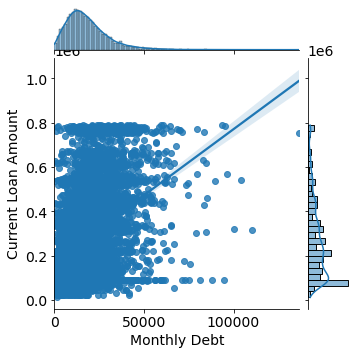

In [38]:
grid = sns.jointplot(dftr['Monthly Debt'], dftr['Current Loan Amount'], kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)
plt.show()

#### В признаке Credit Score обнаружены аномальные значения (> 1000), к которым, вероятно, ошибочно приписан лишний 0. Делим аномальные значения на 10, чтобы привести в правильный формат.

<AxesSubplot:>

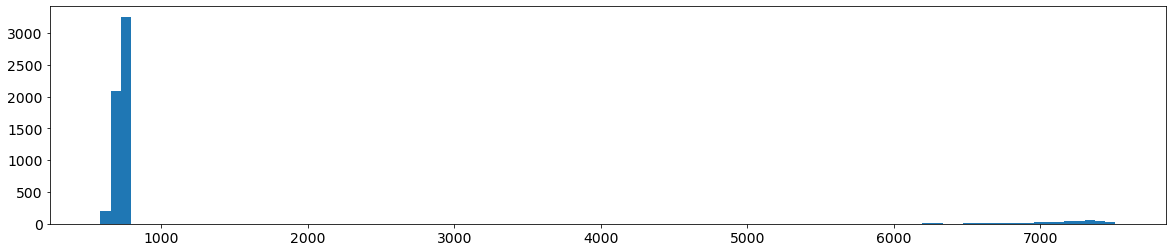

In [39]:
dftr['Credit Score'].hist(figsize=(20,4), bins=100, grid=False)

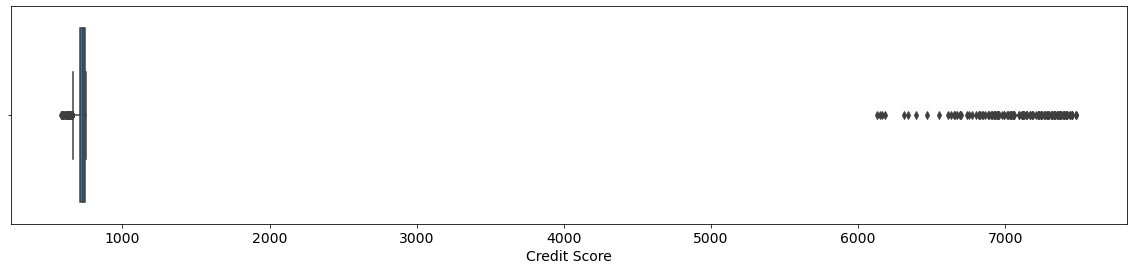

In [40]:
plt.figure(figsize=(20, 4))
sns.boxplot(dftst['Credit Score'])
plt.show()

In [41]:
dftr.loc[dftr['Credit Score']>1000, 'Credit Score'] = (dftr.loc[dftr['Credit Score']>1000, 'Credit Score'])/10
dftst.loc[dftst['Credit Score']>1000, 'Credit Score'] = (dftst.loc[dftst['Credit Score']>1000, 'Credit Score'])/10

<AxesSubplot:>

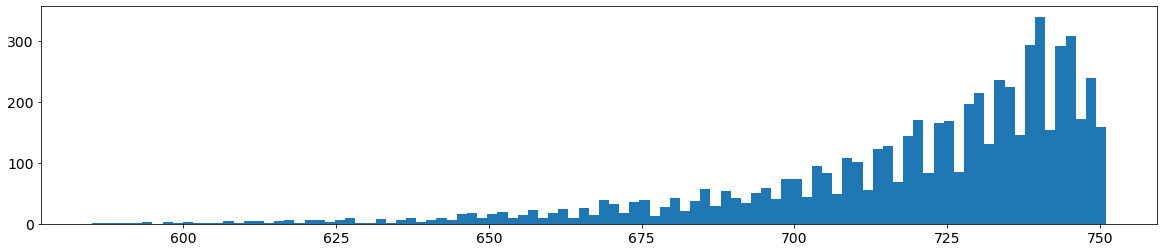

In [42]:
dftr['Credit Score'].hist(figsize=(20,4), bins=100, grid=False)

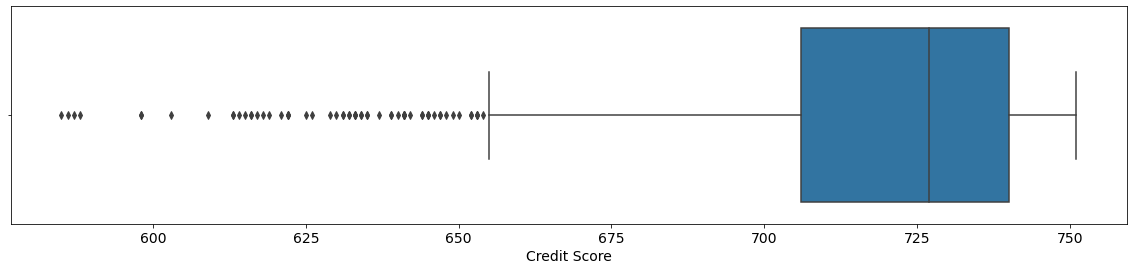

In [43]:
plt.figure(figsize=(20, 4))
sns.boxplot(dftst['Credit Score'])
plt.show()

#### Быстрая контрольная проверка на отрицательные значения:

In [44]:
for i in dftr.select_dtypes(include='float64').columns:
    print(str(i) +' - '+  str((dftr[i] < 0).sum()))

print('*'*30)
    
for i in dftst.select_dtypes(include='float64').columns:
    print(str(i) +' - '+  str((dftst[i] < 0).sum()))

Annual Income - 0
Number of Open Accounts - 0
Years of Credit History - 0
Maximum Open Credit - 0
Number of Credit Problems - 0
Months since last delinquent - 0
Bankruptcies - 0
Current Loan Amount - 0
Current Credit Balance - 0
Monthly Debt - 0
Credit Score - 0
******************************
Annual Income - 0
Number of Open Accounts - 0
Years of Credit History - 0
Maximum Open Credit - 0
Number of Credit Problems - 0
Months since last delinquent - 0
Bankruptcies - 0
Current Loan Amount - 0
Current Credit Balance - 0
Monthly Debt - 0
Credit Score - 0


### Устранение отсутствующих значений.

#### Быстрая статистика по пропускам:

In [45]:
for i in dftr.columns:
    if ((dftr[i].isnull()).sum(axis = 0)) > 0:
        print(str(i) +' - '+  str((dftr[i].isnull()).sum(axis = 0)))

print('*'*30)
    
for i in dftst.columns:
    if ((dftr[i].isnull()).sum(axis = 0)) > 0:
        print(str(i) +' - '+  str((dftst[i].isnull()).sum(axis = 0)))

Annual Income - 1557
Years in current job - 371
Months since last delinquent - 4082
Bankruptcies - 14
Credit Score - 1557
******************************
Annual Income - 513
Years in current job - 86
Months since last delinquent - 1358
Bankruptcies - 3
Credit Score - 513


#### Графическое представление пропущенных значений:

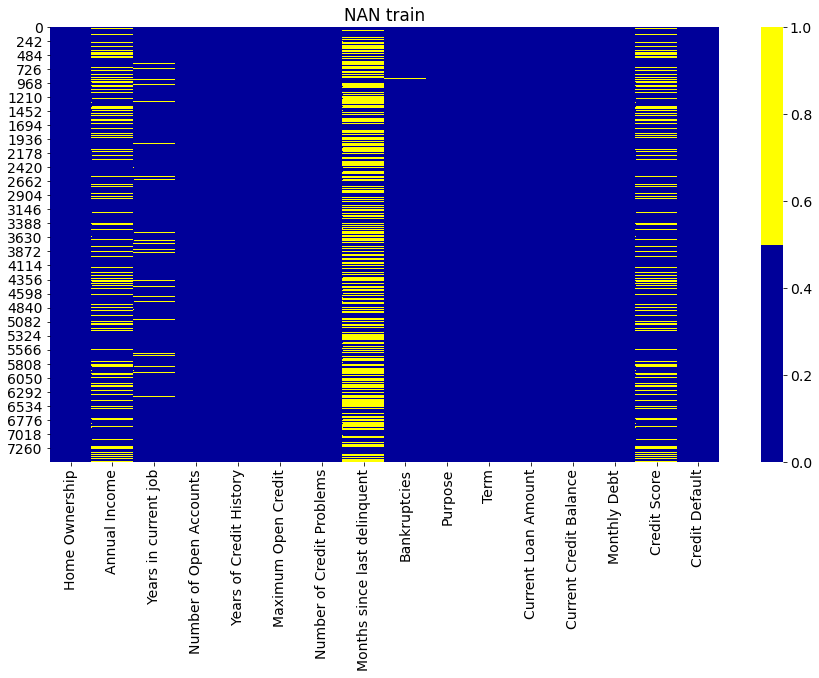

In [46]:
plt.figure(figsize = (15,8))
cols = dftr.columns[:30] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(dftr[cols].isnull(), cmap=sns.color_palette(colours))
plt.title('NAN train')
plt.show()

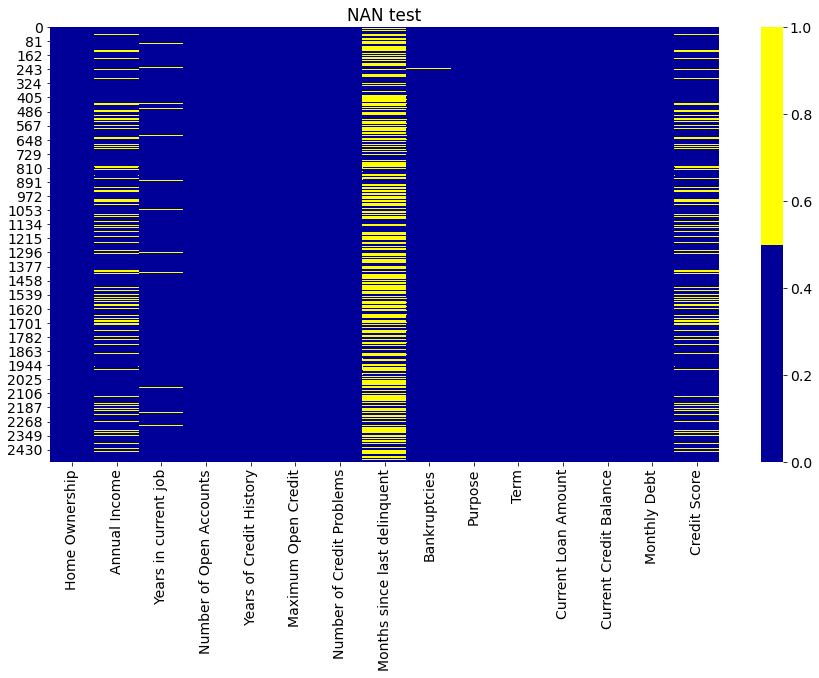

In [47]:
plt.figure(figsize = (15,8))
cols = dftst.columns[:30] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(dftst[cols].isnull(), cmap=sns.color_palette(colours))
plt.title('NAN test')
plt.show()

#### Признак Annual Income - пропуски заменяем на медиану.

In [48]:
mediantr = int(dftr['Annual Income'].median())
mediantst = int(dftst['Annual Income'].median())
dftr['Annual Income'].fillna(mediantr, inplace = True)
dftst['Annual Income'].fillna(mediantst, inplace = True)

#### Признак Years in current job - пропуски заменяем на моду.

In [49]:
mediantr = dftr['Years in current job'].mode()[0]
mediantst = dftst['Years in current job'].mode()[0]
dftr['Years in current job'].fillna(mediantr, inplace = True)
dftst['Years in current job'].fillna(mediantst, inplace = True)

#### Признак Months since last delinquent имеет значительное количество пропусков (~ 43%). Можно предположить, что отсутстве информации обозначает нулевое значение. Заменяем пропуски на 0.

In [50]:
dftr['Months since last delinquent'].fillna(0, inplace = True)
dftst['Months since last delinquent'].fillna(0, inplace = True)

#### В признаке Bankruptcies немного пропусков. Заменяем на медиану.

In [51]:
mediantr = int(dftr['Bankruptcies'].median())
mediantst = int(dftst['Bankruptcies'].median())
dftr['Bankruptcies'].fillna(mediantr, inplace = True)
dftst['Bankruptcies'].fillna(mediantst, inplace = True)

#### В признаке Credit Score пропуски заменяем медианой.

In [52]:
mediantr = int(dftr['Credit Score'].median())
mediantst = int(dftst['Credit Score'].median())
dftr['Credit Score'].fillna(mediantr, inplace = True)
dftst['Credit Score'].fillna(mediantst, inplace = True)

#### Итоговые показатели по отсутствию пропусков (выводится только разделитель, т.к. пропусков в данных больше нет):

In [53]:
for i in dftr.columns:
    if ((dftr[i].isnull()).sum(axis = 0)) > 0:
        print(str(i) +' - '+  str((dftr[i].isnull()).sum(axis = 0)))

print('-'*30)
    
for i in dftst.columns:
    if ((dftr[i].isnull()).sum(axis = 0)) > 0:
        print(str(i) +' - '+  str((dftst[i].isnull()).sum(axis = 0)))

------------------------------


#### Выявились нулевые значения признака Maximum Open Credit при положительном Monthly Debt. Заменяем нулевые значения на средние значения, соответствующие признаку Current Loan Amount в диапазонах 108000 - 339000 и 275000 - 550000 соответственно.

In [54]:
dftr[(dftr['Maximum Open Credit'] == 0) & (dftr['Monthly Debt'] > 0)].head()

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,1161432.0,5 years,17.0,15.7,0.0,1.0,0.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,729.0,0
91,Rent,601369.0,10+ years,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,3.0,8.8,0.0,0.0,0.0,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,6.0,21.1,0.0,0.0,0.0,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0
309,Rent,1245792.0,3 years,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,0.0,395.0,659.0,0


In [55]:
dftst[(dftst['Maximum Open Credit'] == 0) & (dftst['Monthly Debt'] > 0)].head()

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
311,Home Mortgage,1230440.0,1 year,10.0,16.2,0.0,0.0,0.0,0.0,other,Long Term,547976.0,0.0,308.0,701.0
426,Rent,361760.0,< 1 year,4.0,11.6,0.0,0.0,0.0,0.0,debt consolidation,Short Term,15422.0,0.0,3738.0,718.0
1036,Home Mortgage,2328906.0,5 years,4.0,16.4,0.0,0.0,0.0,0.0,other,Short Term,434940.0,51775.0,3125.0,735.0
1343,Home Mortgage,2400061.0,10+ years,1.0,17.0,0.0,0.0,51.0,0.0,debt consolidation,Short Term,494648.0,0.0,1500.0,709.0
1373,Rent,1164225.0,< 1 year,5.0,10.7,0.0,0.0,0.0,0.0,other,Short Term,276452.0,11533.0,283.0,727.0


In [56]:
dftr.loc[dftr['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = dftr.loc[dftr['Current Loan Amount'].between(108000, 339000, inclusive=True), 'Current Loan Amount'].median()
dftst.loc[dftst['Maximum Open Credit'] == 0, 'Maximum Open Credit'] = dftst.loc[dftst['Current Loan Amount'].between(275000, 550000, inclusive=True), 'Current Loan Amount'].median()

#### Выявлены нулевые значения Monthly Debt при положительных значениях Current Loan Amount. Заменяем нулевые значения на средние значения, соответствующие признаку Current Loan Amount в диапазоне 75000 - 333000.

In [57]:
dftr[(dftr['Monthly Debt'] == 0) & (dftr['Current Loan Amount'] > 0)].head()

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.0,10+ years,2.0,16.5,219626.0,0.0,66.0,0.0,home improvements,Short Term,75350.0,0.0,0.0,704.0,0
1643,Rent,1161432.0,9 years,3.0,10.0,219626.0,0.0,0.0,0.0,other,Short Term,332156.0,0.0,0.0,729.0,1
3219,Home Mortgage,1161432.0,10+ years,3.0,18.5,219626.0,0.0,0.0,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,729.0,0
3496,Rent,233567.0,1 year,7.0,11.7,219626.0,0.0,0.0,0.0,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0
4165,Rent,1254513.0,10+ years,6.0,23.4,219626.0,0.0,60.0,0.0,take a trip,Short Term,89298.0,0.0,0.0,748.0,0


In [58]:
dftr.loc[dftr['Monthly Debt'] == 0, 'Monthly Debt'] = dftr.loc[dftr['Current Loan Amount'].between(75000, 333000, inclusive=True), 'Current Loan Amount'].median()

### После устранения пропусков возможно приведение типов переменных.

#### В виду отсутствия дробных значений в датасете, приводим все признаки к типу int, немного сэкономив памяти.

In [59]:
for colname in ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
               'Current Credit Balance', 'Monthly Debt', 'Credit Score']:
    dftr[colname] = dftr[colname].astype(int)
    
for colname in ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
               'Current Credit Balance', 'Monthly Debt', 'Credit Score']:
    dftst[colname] = dftst[colname].astype(int)

In [60]:
dftr.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Home Ownership                7500 non-null   object
 1   Annual Income                 7500 non-null   int32 
 2   Years in current job          7500 non-null   object
 3   Number of Open Accounts       7500 non-null   int32 
 4   Years of Credit History       7500 non-null   int32 
 5   Maximum Open Credit           7500 non-null   int32 
 6   Number of Credit Problems     7500 non-null   int32 
 7   Months since last delinquent  7500 non-null   int32 
 8   Bankruptcies                  7500 non-null   int32 
 9   Purpose                       7500 non-null   object
 10  Term                          7500 non-null   object
 11  Current Loan Amount           7500 non-null   int32 
 12  Current Credit Balance        7500 non-null   int32 
 13  Monthly Debt      

In [61]:
dftst.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Home Ownership                2500 non-null   object
 1   Annual Income                 2500 non-null   int32 
 2   Years in current job          2500 non-null   object
 3   Number of Open Accounts       2500 non-null   int32 
 4   Years of Credit History       2500 non-null   int32 
 5   Maximum Open Credit           2500 non-null   int32 
 6   Number of Credit Problems     2500 non-null   int32 
 7   Months since last delinquent  2500 non-null   int32 
 8   Bankruptcies                  2500 non-null   int32 
 9   Purpose                       2500 non-null   object
 10  Term                          2500 non-null   object
 11  Current Loan Amount           2500 non-null   int32 
 12  Current Credit Balance        2500 non-null   int32 
 13  Monthly Debt      

#### Переводим номинативные признаки Home Ownership, Years in current job и Purpose в категориальные, а Term в бинарный.

In [62]:
cleanup_nums = {"Home Ownership":     {"Home Mortgage": 1, "Rent": 2, 'Own Home': 3},
                "Years in current job": {"10+ years": 10, "9 years": 9, "8 years": 8, "7 years": 7,
                                  "6 years": 6, "5 years": 5, "4 years":4, '3 years':3, '2 years':2,
                                  '1 year':1, '< 1 year': 0},
                'Purpose': {'debt consolidation': 1, 'other': 2, 'home improvements': 3, 'business loan': 4,
                           'buy a car': 5, 'medical bills': 6, 'major purchase':7, 'take a trip':8,
                           'buy house': 9, 'small business': 10, 'wedding':11, 'moving':12, 'educational expenses':13,
                           'vacation':14, 'renewable energy':15},
                'Term': {'Short Term': 0, 'Long Term':1}}

In [63]:
dftr = dftr.replace(cleanup_nums)
dftst = dftst.replace(cleanup_nums)

In [64]:
dftr.head()

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,3,482087,10,11,26,685960,1,0,1,1,0,89298,47386,7914,749,0
1,3,1025487,10,15,15,1181730,0,0,0,1,1,264968,394972,18373,737,1
2,1,751412,8,11,35,1182434,0,0,0,1,0,89298,308389,13651,742,0
3,3,805068,6,8,22,147400,1,0,1,1,0,121396,95855,11338,694,0
4,2,776264,8,13,13,385836,1,0,0,1,0,125840,93309,7180,719,0


In [65]:
dftst.head()

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,2,1164225,4,9,12,220968,0,70,0,1,0,162470,105906,6813,727
1,2,231838,1,6,32,55946,0,8,0,13,0,78298,46037,2318,699
2,1,1152540,3,10,13,204600,0,0,0,1,0,200178,146490,18729,726
3,1,1220313,10,16,17,456302,0,70,0,1,0,217382,213199,27559,739
4,1,2340952,6,11,23,1207272,0,0,0,1,1,777634,425391,42605,706


### Промежуточное сохранение датасета:

In [66]:
dftr.to_csv(TRAIN_PREPARED_DATASET_PATH, sep=",", index=False)
dftst.to_csv(TEST_PREPARED_DATASET_PATH, sep=",", index=False)

### Загрузка датасета:

In [67]:
TRAIN_DATASET_PATH = './/course_project_train.csv'
TEST_DATASET_PATH = './/course_project_test.csv'
TRAIN_PREPARED_DATASET_PATH = './/prepared_train_DS_2.csv'
TEST_PREPARED_DATASET_PATH = './/prepared_test_DS_2.csv'

dftr = pd.read_csv(TRAIN_PREPARED_DATASET_PATH)
dftst = pd.read_csv(TEST_PREPARED_DATASET_PATH)

#### Выделение целевой переменной и групп признаков:

In [68]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = dftr.columns.drop(TARGET_NAME).tolist()

### Анализ целевой переменной.

#### Обзор распределения:

In [69]:
dftr[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

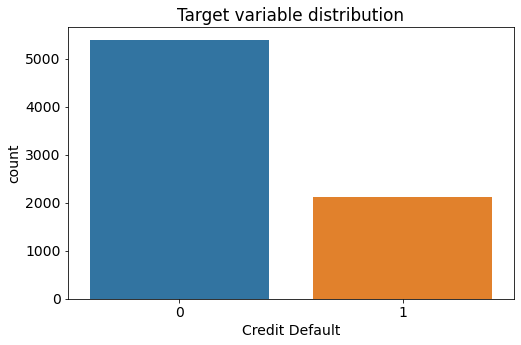

In [70]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=dftr)

plt.title('Target variable distribution')
plt.show()

#### На графике виден явный дисбаланс целевой переменной, который будет сглаживаться позже.

#### Корреляция с базовыми признаками:

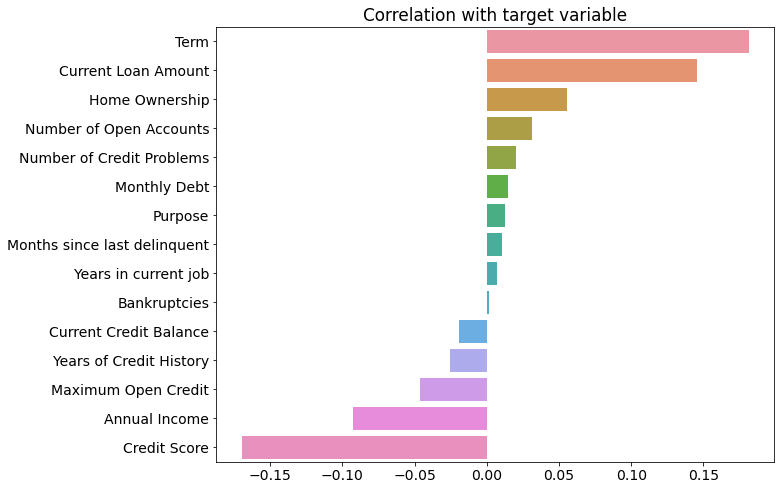

In [71]:
corr_with_target = dftr[FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Оценка признака "Home Ownership" в разрезе целевой переменной:

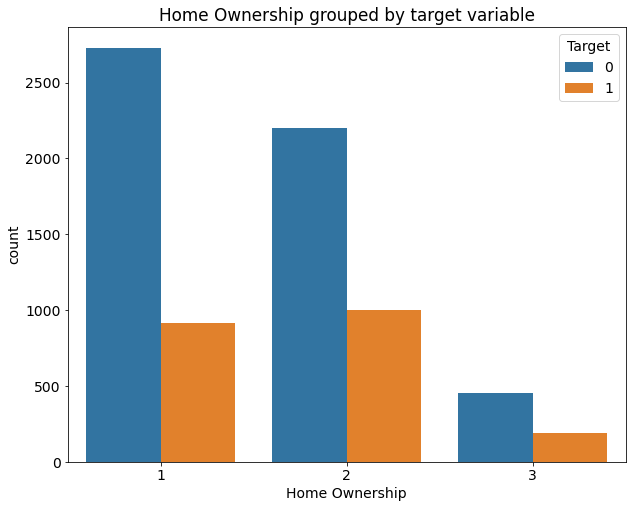

In [72]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=dftr)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

#### Наблюдение:

#### Изучив получившийся график, видно, что значения 1 (Home Mortgage) и 2 (Rent) признака Home Ownership имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

#### Гипотеза:

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости: 0.05
* Критическая область: двухсторонняя

#### Формирование выборки и расчет наблюдаемых частот:

In [73]:
dftr['ID'] = dftr.index

In [74]:
sss = dftr.loc[dftr['Home Ownership'].isin([1, 2]), ['ID', 'Home Ownership', 'Credit Default']].sample(1000, random_state=42)

In [75]:
table = sss.pivot_table(values='ID', index='Home Ownership', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
1,410,135
2,308,147


#### Проверка гипотезы по критерию Хи-квадрата Пирсона:

In [76]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.008348058926751984

#### Повторное формирование выборки и проверка гипотезы:

In [77]:
sss = dftr.loc[dftr['Home Ownership'].isin([1, 2]), ['ID', 'Home Ownership', 'Credit Default']].sample(1000, random_state=12)
table = sss.pivot_table(values='ID', index='Home Ownership', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
1,401,152
2,307,140


In [78]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.184984188262754

In [79]:
dftr.drop(['ID'], axis = 1, inplace = True)

#### В результате двух проверок гипотезы, в первом случае P-value получилось меньше выбранного уровня значимости, а во втором больше, что не позволяет нам однозначно сказать одинаково или нет категории Home Mortgage и Rent влияют на целевую переменную и стоит ли их объединять.

### Оценка признака "Current Loan Amount" в разрезе целевой переменной:

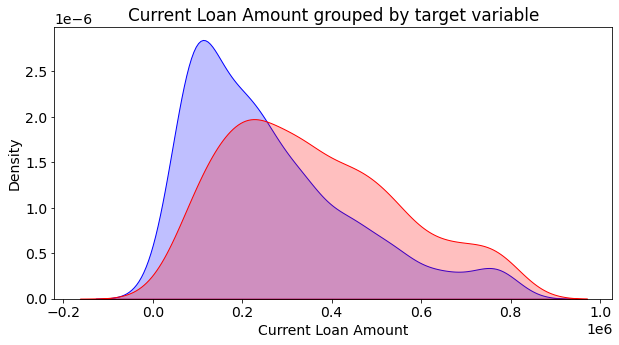

In [80]:
CLA_with_target_s = dftr[['Current Loan Amount', TARGET_NAME]].sample(1000)
CLA_s = CLA_with_target_s['Current Loan Amount']
CLA_target_0 = CLA_s[CLA_with_target_s[TARGET_NAME] == 0]
CLA_target_1 = CLA_s[CLA_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(CLA_target_0, shade=True, label='No default', color='b')
sns.kdeplot(CLA_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

#### Наблюдение:

#### Две группы, полученные в результате разбиения признака "Current Loan Amount" по целевой переменной, вероятно имеют различные распределения. Между признаком "Current Loan Amount" и целевой переменной, возможно, существует некоторая функциональная зависимость.

#### Гипотеза:

* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости: 0.05
* Критическая область: двухсторонняя

In [81]:
shapiro(CLA_s)

ShapiroResult(statistic=0.9136602282524109, pvalue=2.100043024095684e-23)

#### Гипотеза о нормальности распределения отвергается, т.к. pvalue <<< уровня значимости.

#### Визуальная оценка распределения признака и QQ-график:

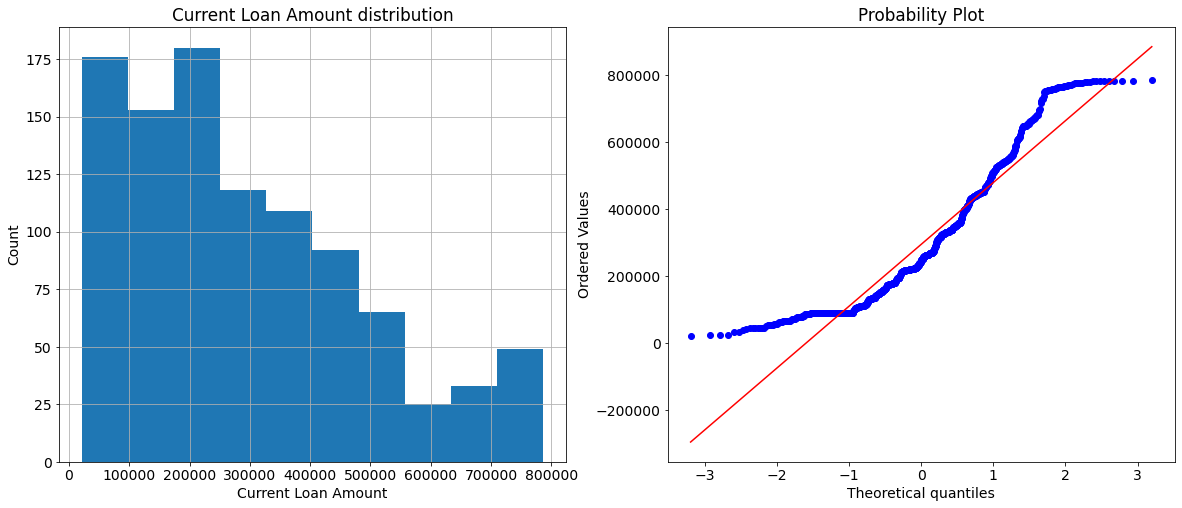

In [82]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
CLA_s.hist()

plt.subplot(122)
probplot(CLA_s, dist='norm', plot=plt)

plt.show()

#### По графикам видно явное отличное от нормального распределение признака. В связи с этим мы не можем использовать критерий Стьюдента. Поэтому используем критерий Манна-Уитни, не требовательный к нормальному распределению.

In [83]:
mannwhitneyu(CLA_target_0, CLA_target_1)

MannwhitneyuResult(statistic=74158.5, pvalue=5.42969989393748e-15)

#### В связи с тем, что pvalue <<< уровня значимости, нулевая гипотеза отвергается.

#### Построение доверительных интервалов для средних значений, каждой из двух групп признака Current Loan Amount:

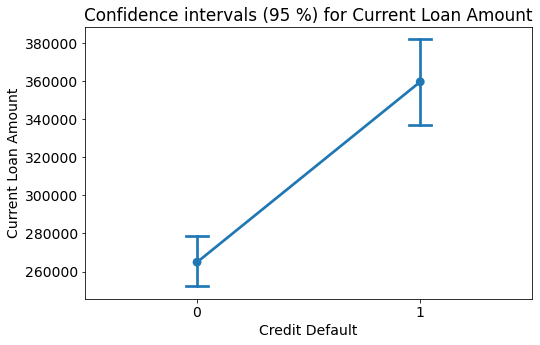

In [84]:
plt.figure(figsize=(8, 5))
sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=CLA_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

#### График показывает, что интервалы, в которых с 95% вероятностью должны находиться средние значения двух групп признака Current Loan Amount, не пересекаются, что подтверждает показатели критерия Манна-Уитни, и говорит, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и признак Current Loan Amount может быть полезен для определения значения целевой переменной.

### Анализ распределения нецелевых признаков:

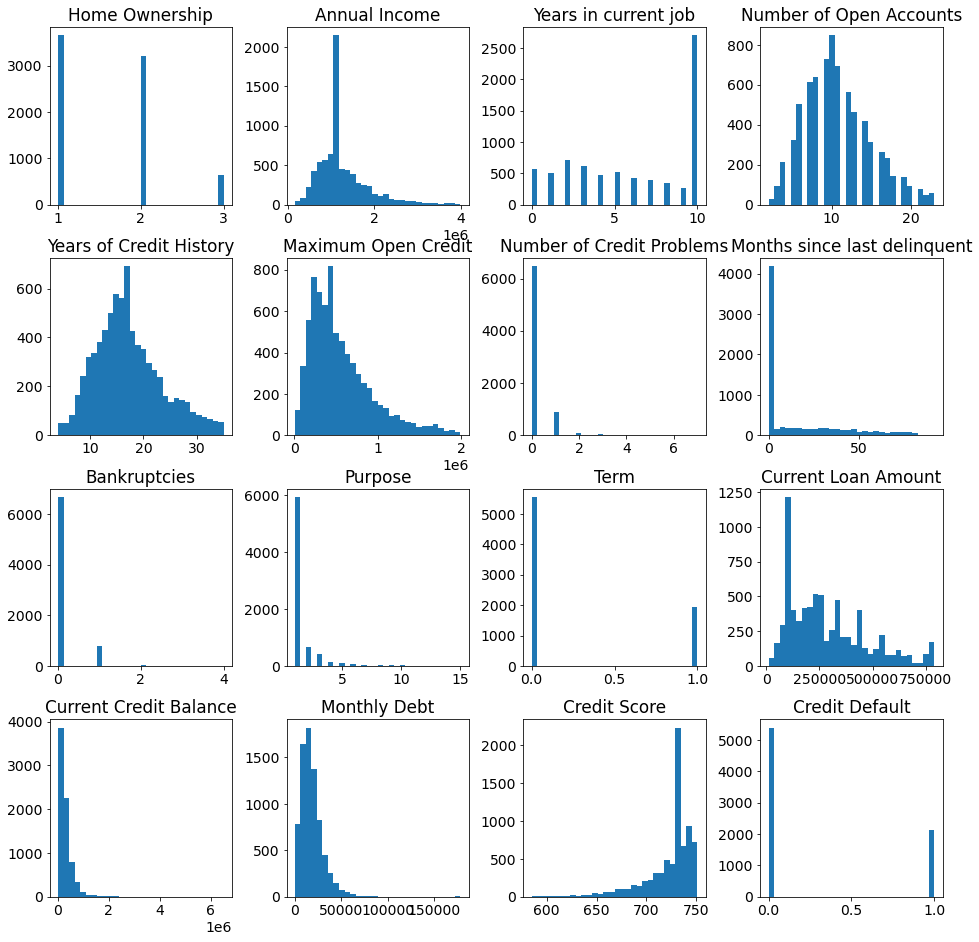

In [85]:
dftr.hist(figsize=(16,16), bins=30, grid=False);

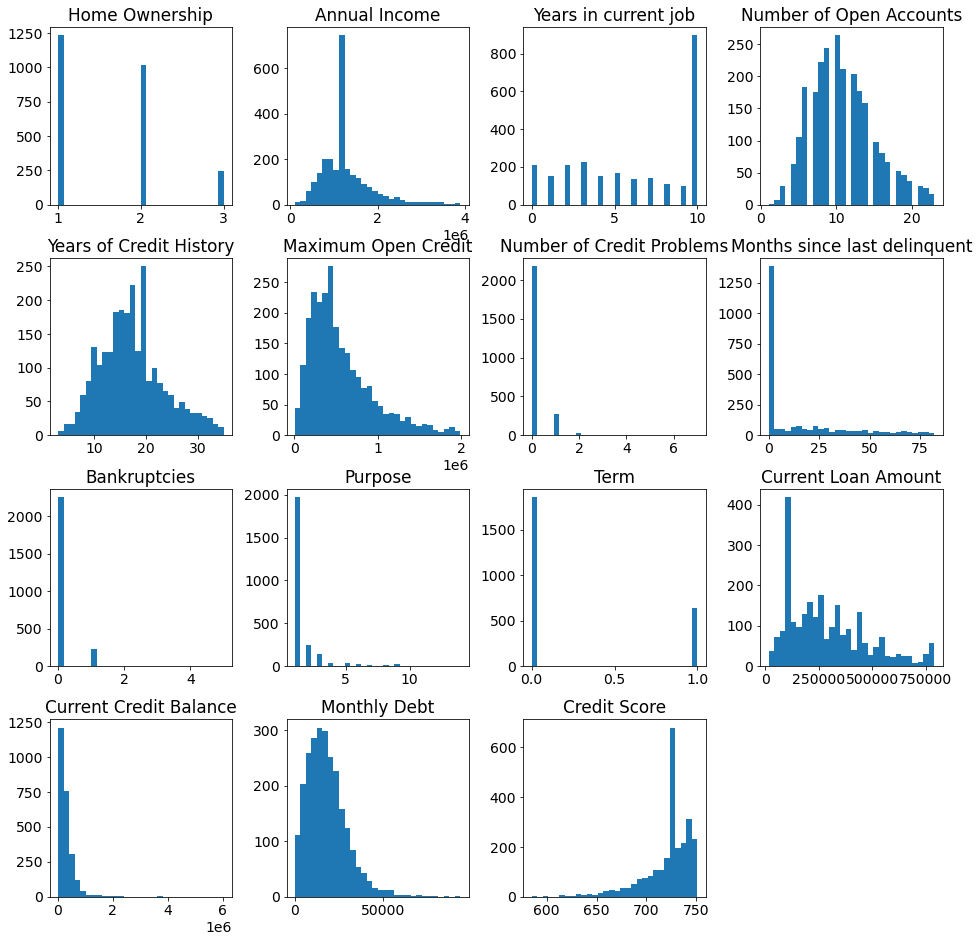

In [86]:
dftst.hist(figsize=(16,16), bins=30, grid=False);

#### При анализе распределения нецелевых признаков видно, что из-за обработки выбросов и пропусков была нарушена плавность распределения некоторых признаков.

### Матрица корреляций:

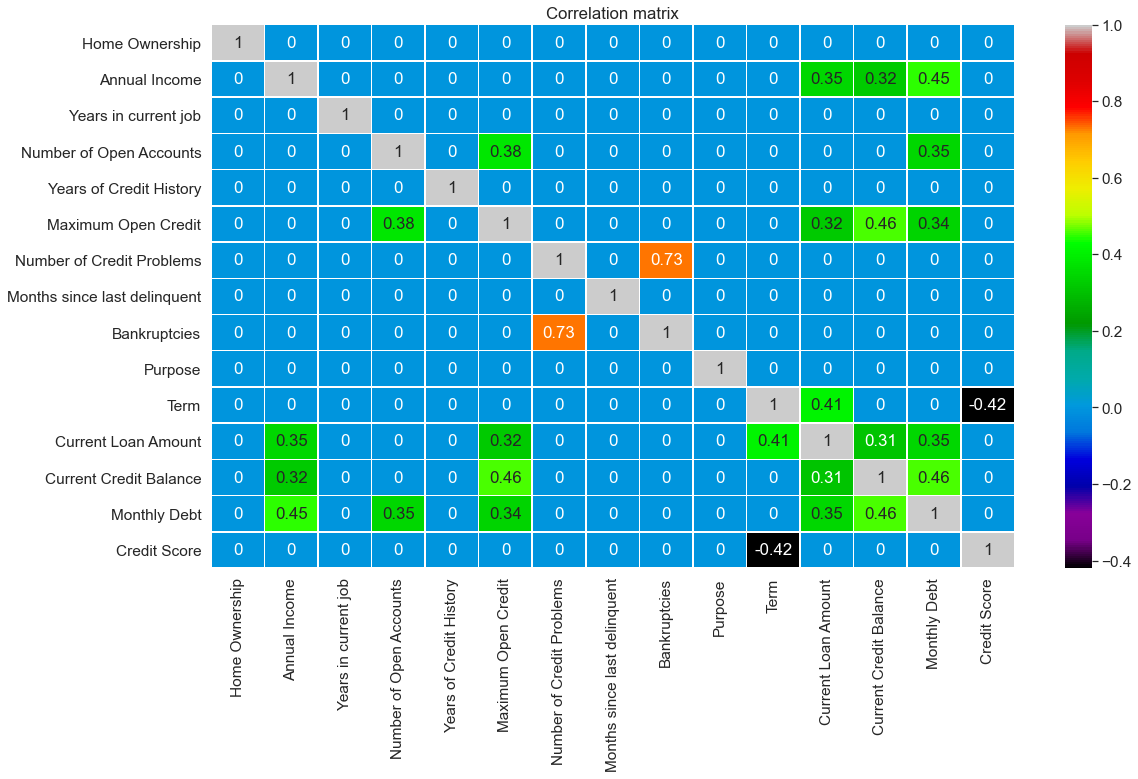

In [87]:
plt.figure(figsize = (18,10))

sns.set(font_scale=1.4)

corr_matrix = dftr[FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='nipy_spectral')

plt.title('Correlation matrix')
plt.show()

#### Признак Bankruptcies сильно коррелирован с признаком Number of Credit Problems, что создает проблему мультиколлинеарности. И т.к. признак Bankruptcies показал корреляцию с целевым признаком меньшую, чем Number of Credit Problems, принято решение удалить из датасета именно его.

In [88]:
dftr.drop('Bankruptcies', axis=1, inplace=True)
dftst.drop('Bankruptcies', axis=1, inplace=True)

### Отобор признаков.

#### Не имеющие практической пользы признаки были ранее удалены. Оставшиеся признаки разбиваются на числовые и категориальные.

In [89]:
NUM_FEATURE_NAMES = ['Annual Income', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount',
                    'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Number of Open Accounts', 
                     'Years of Credit History', 'Number of Credit Problems']

FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

### Нормализация данных.

In [90]:
scaler = StandardScaler()
dftr[NUM_FEATURE_NAMES] = scaler.fit_transform(dftr[NUM_FEATURE_NAMES])
dftst[NUM_FEATURE_NAMES] = scaler.fit_transform(dftst[NUM_FEATURE_NAMES])

#### После нормализации все данные автоматически приводятся к одному типу - float64.

### Разбиение датасета.

In [91]:
X = dftr[FEATURE_NAMES]
y = dftr[TARGET_NAME]
Test = dftst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=21)

### Балансировка целевой переменной.

In [92]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

#### Алгоритм балансировки на выходе дал 6729 строк для обоих классов целевой переменной, хотя на вход подавалось 5250.

In [93]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей.

#### CatBoost.

#### Приведение типов для модели CatBoost:

#### При сравнении результатов работы модели CatBoost при приведенных к типу Category данных и неприведенных, наилучший показатель был при неприведенных данных. Данные решено было не приводить к типу Category.

#### Построение CatBoost:

In [94]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3771
           1       0.88      0.86      0.87      2958

    accuracy                           0.89      6729
   macro avg       0.89      0.89      0.89      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1616
           1       0.44      0.47      0.46       634

    accuracy                           0.68      2250
   macro avg       0.61      0.62      0.62      2250
weighted avg       0.69      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1235  381
1                333  301


### Подбор гиперпараметров.

In [95]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 4], silent=True, random_state=21)

In [96]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[2, 3, 5, 7]}

In [97]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [98]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 23 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000202343FC1C0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [99]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 5}

In [100]:
rs.best_score_

0.5114026514356637

### Обучение и оценка финальной модели:

#### Автоматический подбор гиперпараметров показал худший результат, чем ручная настройка. Для устранения переобучения добавляем регуляризацию.

In [101]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=2,
                                      l2_leaf_reg=2,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      3771
           1       0.68      0.63      0.65      2958

    accuracy                           0.71      6729
   macro avg       0.70      0.70      0.70      6729
weighted avg       0.70      0.71      0.70      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1616
           1       0.44      0.57      0.50       634

    accuracy                           0.68      2250
   macro avg       0.63      0.64      0.63      2250
weighted avg       0.71      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1160  456
1                272  362
Wall time: 2.2 s


#### Рейтинг признаков:

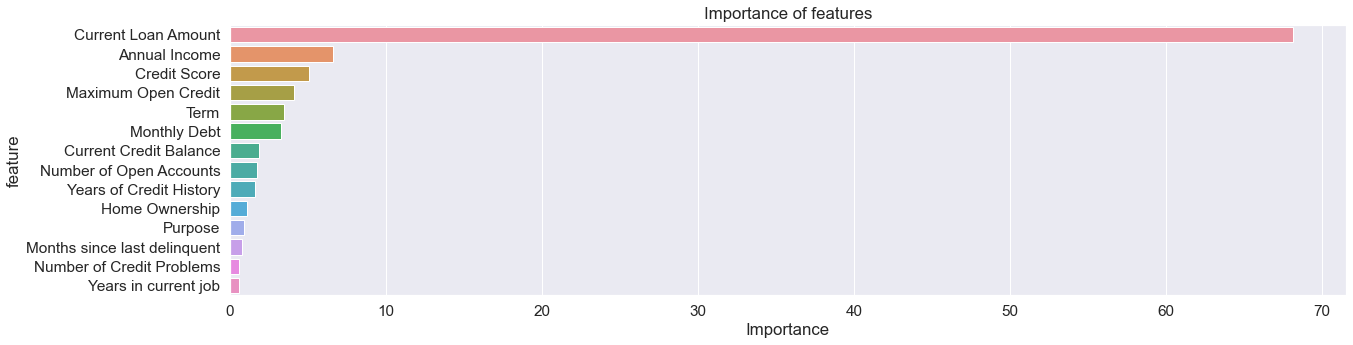

In [102]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=20)

In [103]:
important_features_top

['Current Loan Amount',
 'Annual Income',
 'Credit Score',
 'Maximum Open Credit',
 'Term',
 'Monthly Debt',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Years of Credit History',
 'Home Ownership',
 'Purpose',
 'Months since last delinquent',
 'Number of Credit Problems',
 'Years in current job']

### Финальная модель с учетом рейтинга признаков:

In [104]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1000, max_depth=2,
                                      l2_leaf_reg=2,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      3771
           1       0.68      0.63      0.65      2958

    accuracy                           0.71      6729
   macro avg       0.70      0.70      0.70      6729
weighted avg       0.70      0.71      0.70      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1616
           1       0.44      0.57      0.50       634

    accuracy                           0.67      2250
   macro avg       0.62      0.64      0.63      2250
weighted avg       0.70      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1151  465
1                272  362
Wall time: 2.07 s


### Предсказание по тестовому датасету и запись результатов в файл:

In [105]:
Credit = final_model.predict(Test)

In [106]:
Credit.shape

(2500,)

In [107]:
unique, counts = np.unique(Credit, return_counts=True)
print(unique , counts)

[0 1] [1658  842]


In [108]:
pred_df = pd.DataFrame()
pred_df["Credit"] = Credit
pred_df.to_csv("./predictions_GB_2.csv", header=False, index=False)